# Tully-Fisher Secondary Target Sample

Demonstrate PostgreSQL access to the TF targets in the secondary target database at NERSC.

In [1]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import psycopg2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## Postgres Query

See if we have a cached copy of the query results (in FITS format) before running this query.

For connecting to the database, it is recommended that you store the password and connection port in a secure `.pgpass` file on the system, or create a private INI file that is not committed to GitHub. Connection details are not going to be saved in this notebook. Ask on the #timedomain-general or #peculiar-velocity slack channels for more information.

See the [database wiki page](https://desi.lbl.gov/trac/wiki/DESIDatabase) for information about the location and names of tables and their schema.

In [3]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('tf_targets.fits') and use_cached:
    tf_targets = Table.read('tf_targets.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()

        query = """SELECT DISTINCT pr.pvtype, pr.sga_id, fd.targetid, fd.target_ra, fd.target_dec, zd.z, zd.spectype, zd.deltachi2, zd.zwarn, zd.yyyymmdd
                    FROM fibermap_daily fd
                    INNER JOIN
                        zbest_daily zd ON zd.targetid = fd.targetid
                    INNER JOIN
                        (SELECT targetid, MAX(expid) AS max_expid
                            FROM fibermap_daily
                            GROUP BY targetid) groupfmap
                            ON fd.targetid = groupfmap.targetid AND fd.expid = groupfmap.max_expid
                    INNER JOIN
                        (SELECT targetid, MAX(yyyymmdd) AS max_date
                            FROM zbest_daily
                            GROUP BY targetid) groupzd
                            ON zd.targetid = groupzd.targetid AND zd.yyyymmdd = groupzd.max_date
                    INNER JOIN pv.proposals pr ON (CAST(pr.ra*10000 AS INTEGER) = CAST(fd.target_ra*10000 AS INTEGER)) AND
                                                  (CAST(pr.dec*10000 AS INTEGER) = CAST(fd.target_dec*10000 AS INTEGER))
                    WHERE (pr.pvtype LIKE 'TFT' or pr.pvtype LIKE 'EXT' or pr.pvtype LIKE 'SGA')
                    ORDER BY zd.yyyymmdd;"""

        cursor.execute(query)
        rows = cursor.fetchall()
        tf_targets = Table(list(map(list, zip(*rows))),
                           names=['PVTYPE', 'SGA_ID', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'Z', 'SPECTYPE', 'DELTACHI2', 'ZWARN', 'YYYYMMDD'])
        tf_targets.write('tf_targets.fits', overwrite=True)
        
    except (Exception, psycopg2.Exception) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
tf_targets

PVTYPE,SGA_ID,TARGETID,TARGET_RA,TARGET_DEC,Z,SPECTYPE,DELTACHI2,ZWARN,YYYYMMDD
bytes3,int64,int64,float64,float64,float64,bytes6,float64,int64,int64
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,GALAXY,33952.1068879628,0,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,GALAXY,53137.0094233155,0,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,GALAXY,33245.3577982187,0,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,GALAXY,11625.5793859102,0,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,GALAXY,57099.7675513407,0,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,GALAXY,12976.2707899213,0,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,GALAXY,4275.01541189849,0,20201222
TFT,269195,39628462834585206,35.9738797902803,29.3592905954632,-0.00199570145091582,STAR,1.94266889222573e+84,1570,20201222


In [4]:
np.unique(tf_targets['PVTYPE'], return_counts=True)

(<Column name='PVTYPE' dtype='bytes3' length=3>
 EXT
 SGA
 TFT,
 array([  303,  6191, 19003]))

## Plot Target Coordinates

In [5]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PVTYPE'])
    for class_name in class_names:
        select = table['PVTYPE'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['TARGET_RA'])
        _dec = np.radians(table[select]['TARGET_DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

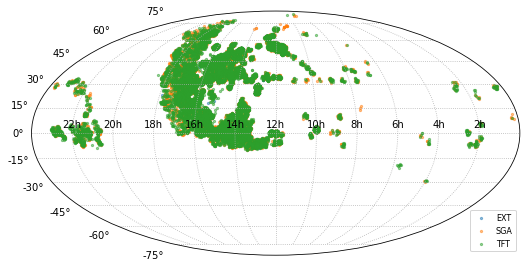

In [6]:
fig = plot_radec(tf_targets)

## Plot Target Redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [7]:
isgoodz = (tf_targets['DELTACHI2']>= 25) & (tf_targets['ZWARN']==0)
np.sum(isgoodz)

19480

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


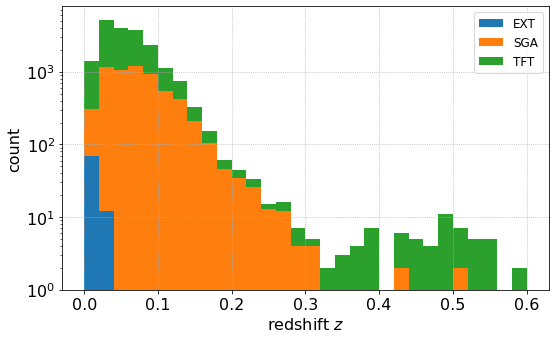

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_targets['PVTYPE'])
for pvtype in pvtypes:
    ispvtype = tf_targets['PVTYPE'] == pvtype
    zdata.append(list(tf_targets[isgoodz & ispvtype]['Z']))

zbins = np.linspace(0,0.6,31)
ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)
ax.set(#ylim=(0,15),
       xlabel='redshift $z$',
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

## Select Good Reshifts with Unique TARGETIDs

In [9]:
uniq_targ, uniq_targ_idx = np.unique(tf_targets[isgoodz]['TARGETID'], return_index=True)
tf_subtab = tf_targets[isgoodz][uniq_targ_idx]
tf_subtab

PVTYPE,SGA_ID,TARGETID,TARGET_RA,TARGET_DEC,Z,SPECTYPE,DELTACHI2,ZWARN,YYYYMMDD
bytes3,int64,int64,float64,float64,float64,bytes6,float64,int64,int64
SGA,995236,1009771901616128,192.166586851347,62.6175481394664,0.105593717960875,GALAXY,23481.8310179189,0,20210501
TFT,482290,1070066330238978,219.744023124629,-2.02173448705947,0.116882436569021,GALAXY,481.637736558914,0,20210508
TFT,482290,1070066330238980,219.746535239762,-2.01779238668629,0.0568060570569879,GALAXY,45.1837179791182,0,20210430
TFT,90791,1070072240013321,211.957886832204,-1.65159791419012,0.0552947827650302,GALAXY,111.245351357618,0,20210517
TFT,90791,1070072240013322,211.959006708595,-1.65473654112272,0.0542300235126384,GALAXY,253.668385469005,0,20210510
TFT,826026,1070072273567746,213.817950420643,-1.71881457950618,0.0480220453060238,GALAXY,305.3978115879,0,20210513
TFT,564310,1070072311316485,216.100293805261,-1.76607120608847,0.0557093434513551,GALAXY,60.1138700004667,0,20210505
TFT,564310,1070072311316486,216.101759176259,-1.76374501503341,0.0565124361453059,GALAXY,331.740518108709,0,20210510
TFT,812997,1070072319705092,216.659674438654,-1.64463157115269,0.0569686780799887,GALAXY,2316.75004354119,0,20210507


In [10]:
ids, counts = np.unique(tf_subtab['SGA_ID'], return_counts=True)

### Count SGA Galaxies with More than 1 Observation

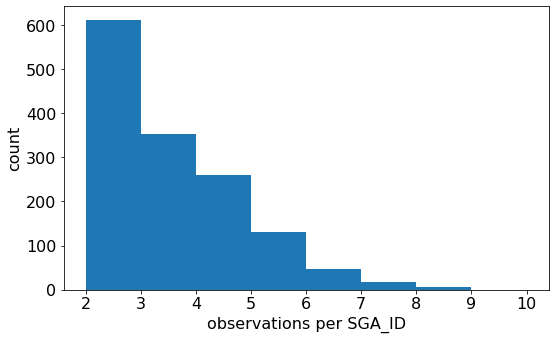

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)
ax.hist(counts[counts > 1], bins=np.linspace(2,10,9))
ax.set(xlabel='observations per SGA_ID',
       ylabel='count');